In [3]:
import pymongo
import json
import matplotlib.pyplot as plt
import numpy as np

In [4]:
with open('../config.json', 'r') as file:
    config = json.load(file)

mongo_uri = config['mongo_uri']
database_name = config['database_name']
softwares_collection = config['container_softwares']
machines_collection = config['container_machines']

In [5]:
client = pymongo.MongoClient(mongo_uri)
    
# Select the database
db = client[database_name]

# Collection for store software data
softwares_clt = db[softwares_collection]

# Collection for store machine data
machines_clt = db[machines_collection]

In [6]:
def get_vulnerable_softwares():
    """
    Get all softwares with vulnerabilities in the database
    Args: None
    Returns: A list of softwares with vulnerabilities    
    """
    vulnerable_softwares = softwares_clt.find({'vulnerabilities': {'$not': {'$size': 0}}}, {'_id': 0})
    return vulnerable_softwares

In [7]:
def impact_vulnerabilities(vulnerable_softwares):
    """
    Create a chart of horizontal bars with the impact of all vulnerabilities (low, medium, high, critical)
    Args: None
    Returns: None
    """
    impact = { 
              'UNKNOWN': 0,
              'LOW': 0,
              'MEDIUM': 0,
              'HIGH': 0,
              'CRITICAL': 0
              }
    for software in vulnerable_softwares:
        for vulnerability in software['vulnerabilities']:
            severity = "UNKNOWN"
            if 'baseSeverity' in vulnerability['metrics']:
                severity = vulnerability['metrics']['baseSeverity']
            if severity in impact:
                impact[severity] += 1
            else:
                impact[severity] += 1

                
    colors = ["#475387","#edc40c","#ed6d0c","#c90e0e","#111111"]
    
    for i, v in enumerate(list(impact.values())):
        plt.text(v + 5 , i, str(v), 
            color = '#1f6b46', fontweight = 'bold')
        
    plt.grid(True, zorder = 1)
    plt.barh(list(impact.keys()), list(impact.values()), color=colors, zorder = 2)
    plt.xlim(0, max(impact.values()) + 20)
    plt.xlabel('Number of vulnerabilities')
    plt.ylabel('Impact')
    plt.title('Impact of vulnerabilities')
    plt.show()
            

In [8]:
def chart_top_ten_vulnerable_softwares():
    """
    Create a pie chart with the top ten softwares with more vulnerabilities
    the top ten softwares are sorted by the number of vulnerabilities and its calculated with 
    the field 'totalVulnerabilities' in the database
    The average number of vulnerabilities is represented with a dashed red line
    Args: None
    Returns: None
    """
    # get all softwares with vulnerabilities sorted by totalVulnerabilities field
    softwares_sorted = list(softwares_clt.find({'vulnerabilities': {'$not': {'$size': 0}}}, {'_id': 0}).sort('totalVulnerabilities', -1))
    average_number_of_vulnerabilities = sum([s['totalVulnerabilities'] for s in softwares_sorted]) / len(softwares_sorted)
    top_ten_softwares = softwares_sorted[:6]
    names = [s['name'] for s in top_ten_softwares]
    vulnerabilities = [s['totalVulnerabilities'] for s in top_ten_softwares]
    colors = ["#1A237E","#0D47A1","#01579B","#006064","#004D40","#1B5E20"]
   
    fig, ax = plt.subplots()
    explode = (0.1,0,0,0,0,0,)
    wedges, texts, autotexts = ax.pie(vulnerabilities,shadow = True, labels=names,explode = explode, colors = colors, autopct='%1.1f%%',textprops = dict(color = "w"))
    ax.legend(wedges, names,
          title="Softwares",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title("Top ten softwares with more vulnerabilities")
    plt.setp(autotexts, size=10, weight="bold")
    plt.show()
    
    

        

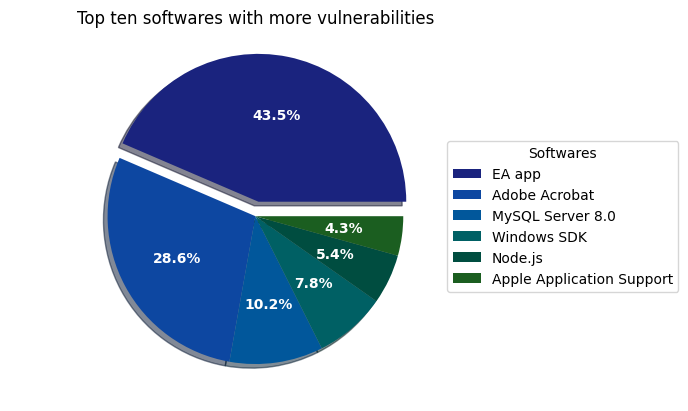

In [9]:
chart_top_ten_vulnerable_softwares()

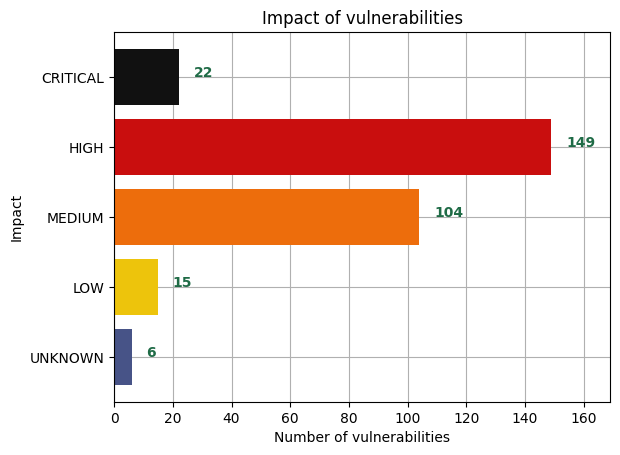

In [10]:
vulnerable_softwares = get_vulnerable_softwares()
impact_vulnerabilities(vulnerable_softwares)

In [11]:
def qty_critical_vulns(vulnerable_softwares):
    """
        Get the number of critical vulnerabilities
        For each vulnerability in a sofwares, check if the severity is critical
        in the field of the software ['vulnerabilities'][item_position]['metrics']['baseSeverity']
        Args: vulnerable_softwares (list): List of softwares with vulnerabilities
        Returns: Number of critical vulnerabilities
    """
    critical_vulns = 0
    for software in vulnerable_softwares:
        for vulnerability in software['vulnerabilities']:
            if 'baseSeverity' in vulnerability['metrics']:
                if vulnerability['metrics']['baseSeverity'] == 'CRITICAL':
                    critical_vulns += 1
                    
    return critical_vulns

In [12]:
def most_vulnerable_machine():
    """
        Get the machine with the most vulnerabilities
        First get a list with the id in machine JSON
        Then for each machine, get the number of softwares vulnerable with that id in the field list  associatedMachines
        Args: None
    """
    id_machines = []
    most_vulnerable_machine = {
        'id': 0,
        'vuln_softwares_qty': 0
    }
    try:
        id_machines = machines_clt.find({}, {'_id':0,'id': 1})
        for id in id_machines:
            vuln_softwares_qty = softwares_clt.count_documents({'associatedMachines': id['id'], 'vulnerabilities': {'$not': {'$size': 0}}})
            if vuln_softwares_qty > most_vulnerable_machine['vuln_softwares_qty']:
                most_vulnerable_machine['id'] = id['id']
                most_vulnerable_machine['vuln_softwares_qty'] = vuln_softwares_qty
    except Exception as e:
        print("Error getting the id machines list",e)
        
    return most_vulnerable_machine

In [13]:
print(json.dumps(most_vulnerable_machine(),indent=2))

{
  "id": "28c8e3cb-0938-429e-b4ce-24039d949df4",
  "vuln_softwares_qty": 19
}


In [14]:
def recent_vulnerabilities_qty(current_year):
    """
        Get the number of vulnerabilities in the current year (2024)
        For each vulnerability in a sofwares, check if the CVE ID contains the current year
        Args: current_year (str): Current year
        Returns: Quantity of vulnerabilities in the current year
    """
    if current_year == None:
        return 0
    current_year = current_year.strip()
    if len(current_year) != 4:
        return 0
    
    recent_vulns = 0
    try:
        #software list with vulnerabilities that have been published in the current year
        softwares = list(softwares_clt.find({'vulnerabilities.CVE_ID': {'$regex': current_year}}, {'_id': 0, 'vulnerabilities': 1}))
        for software in softwares:
            for vulnerability in software['vulnerabilities']:
                if current_year in vulnerability['CVE_ID']:
                    recent_vulns += 1
    except Exception as e:
        print("Error getting the recent vulnerabilities",e)
        
    return recent_vulns

In [15]:
print(recent_vulnerabilities_qty("2024"))

55


In [1]:
def chart_top_ten_riskiest_vulnerabilities():
    """
    Create a chart of three vertical bars by vulnerability with the top ten vulnerabilities with more base score.
    The first bar is the base score, the second is exploitablity score and the third is impact score
    First get only the vulnerability list of all softwares with vulnerabilities, in this list the JSON have only
    four fields: baseScore, exploitabilityScore, impactScore and CVE_ID
    after that the functiont will create a unique list of vulnerabilities and sort by base score, by exploitability score and by impact score
    
    Args: None
    Returns: None
    """
    vulns_shorted_list = []
    try:
        vulns_list = list(softwares_clt.find({'vulnerabilities': {'$not': {'$size': 0}}},{'_id': 0, 'vulnerabilities': 1}))
    except Exception as e:
        print("Error getting the vulnerabilities list ",e)
        return
    
    for vulns in vulns_list:
        if not 'vulnerabilities' in vulns:
            continue
        for vuln in vulns['vulnerabilities']:
            baseScore = vuln['metrics']['baseScore'] if 'baseScore' in vuln['metrics'] else 0
            exploitabilityScore = vuln['metrics']['exploitabilityScore'] if 'exploitabilityScore' in vuln['metrics'] else 0
            impactScore = vuln['metrics']['impactScore'] if 'impactScore' in vuln['metrics'] else 0
            vulnShortedJSON = {
                'CVE_ID': vuln['CVE_ID'],
                'baseScore': baseScore,
                'exploitabilityScore': exploitabilityScore,
                'impactScore': impactScore,
            }
            vulns_shorted_list.append(vulnShortedJSON)
    vulns_shorted_list.sort(key=lambda x: (x['baseScore'], x['impactScore'], x['exploitabilityScore']), reverse=True)
    top_ten_vulns = vulns_shorted_list[:10]
    # Create the chart specified in the function description
    cve_ids = [vuln['CVE_ID'] for vuln in top_ten_vulns]
    base_scores = [vuln['baseScore'] for vuln in top_ten_vulns]
    exploitability_scores = [vuln['exploitabilityScore'] for vuln in top_ten_vulns]
    impact_scores = [vuln['impactScore'] for vuln in top_ten_vulns]
    X_axis = np.arange(len(top_ten_vulns)) 
  
  
    plt.figure(figsize=(12, 6))
    plt.bar(X_axis - 0.4, base_scores, width=0.4, label = 'Base Score', color = '#ff4444')
    plt.bar(X_axis - 0.2, impact_scores, width=0.4, label = 'Impact Score', color = '#ffbb3d')  
    plt.bar(X_axis, exploitability_scores, width=0.4, label = 'Explotability Score', color = '#ff8888') 
    
    plt.ylim(0, 13)  
    plt.yticks(range(1, 13, 1))
    plt.xticks(X_axis-0.3, cve_ids,rotation=45, fontname = 'Arial', fontsize = 10) 
    plt.xlabel("CVE IDENTIFIER", fontsize = 12, fontweight = 'bold',fontname = 'Ms Gothic') 
    plt.ylabel("SCORE", fontsize = 12, fontweight = 'bold',fontname = 'Ms Gothic') 
    plt.title("Scores of the top ten vulnerabilities", fontsize = 16, fontweight = 'bold', fontname = 'Ms Gothic') 
    plt.legend() 
    
    plt.show() 
    
    
    

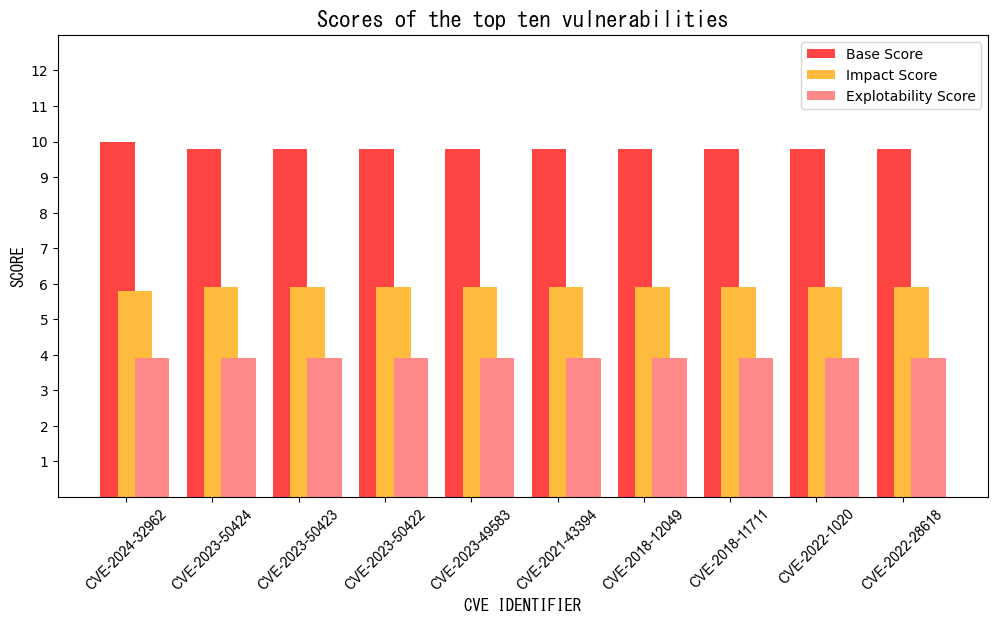

In [16]:
chart_top_ten_riskiest_vulnerabilities()